In [6]:
!pip install seqeval
!pip install transformers
!pip install tqdm

  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16217 sha256=cb97c87355e76096070ea101114d2349f09439a596aa1b4ed6febb156c7a6a75
  Stored in directory: /teamspace/studios/this_studio/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 186.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.7/781.7 kB 106.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 172.4 MB/s eta 0:00:00


In [7]:
import pandas as pd
import torch

from transformers import BertTokenizer, BertForTokenClassification, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from seqeval.metrics import classification_report, f1_score, precision_score, recall_score #


In [23]:
df = pd.read_csv('NER-dataset.csv', encoding="latin-1")

df["Sentence #"] = df["Sentence #"].ffill()
df["Sentence #"] = df["Sentence #"].str.extract(r'(\d+)').astype(int)
df["Word"] = df['Word'].fillna('None')

df["pos_label"] = LabelEncoder().fit_transform(df['POS'])
df["tag_label"] = LabelEncoder().fit_transform(df['Tag'])

df_gr = df.groupby("Sentence #").agg({'Word': list, 'POS':list, 'Tag':list,"tag_label":list,"pos_label":list})

In [24]:
df_small = df_gr
df_small.shape

(47959, 5)

In [25]:
train_df, test_df = train_test_split(df_small, test_size=0.2, random_state=42)

In [26]:
label_list = ['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim', 'I-per', 'I-gpe', 'I-tim']
label_map = {label: i for i, label in enumerate(label_list)} # create mapping for labels to integers
label_map_inv = {i: label for i, label in enumerate(label_list)}

In [27]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

In [28]:
def tokenize_and_align_labels(sentence, labels, tokenizer, label_map):
    tokenized_inputs = []
    aligned_labels = []

    for word, label in zip(sentence, labels):
        tokens = tokenizer.tokenize(word)
        tokenized_inputs.extend(tokens)
        if label in label_list:
            aligned_labels.extend([label_map[label]] + [label_map['O']] * (len(tokens) - 1))
        else:
            aligned_labels.extend([label_map['O']] * len(tokens)) #set all other labels to O.
    return tokenized_inputs, aligned_labels

In [29]:
def create_dataset(dataframe, tokenizer, label_map):
    tokenized_sentences = []
    aligned_labels_list = []

    for sentence, labels in zip(df_small['Word'], df_small['Tag']):
        tokens, aligned_labels = tokenize_and_align_labels(sentence, labels, tokenizer, label_map)
        tokenized_sentences.append(tokens)
        aligned_labels_list.append(aligned_labels)

    input_ids = []
    attention_masks = []

    for tokens in tokenized_sentences:
        encoded = tokenizer.encode_plus(
            tokens,
            add_special_tokens=True,  # Add [CLS] and [SEP]
            is_split_into_words=False, # data are olready tokenised and split to sub words
            max_length= MAX_LEN,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        input_ids.append(encoded['input_ids'][0])
        attention_masks.append(encoded['attention_mask'][0])
        
    padded_labels = []

    for labels in aligned_labels_list:
        pad_len = MAX_LEN - len(labels) - 1 # minus the [CLS] Tag
        padded_label = [label_map['O']] + labels + [label_map['O']] * pad_len # pad labels with 'O'
        padded_labels.append(padded_label)

    class NERDataset(Dataset):
        def __init__(self, input_ids, attention_masks, labels):
            self.input_ids = input_ids
            self.attention_masks = attention_masks
            self.labels = labels

        def __len__(self):
            return len(self.input_ids)

        def __getitem__(self, idx):
            return {
                'input_ids': self.input_ids[idx],
                'attention_mask': self.attention_masks[idx],
                'labels': torch.tensor(self.labels[idx])
            }

    dataset = NERDataset(input_ids, attention_masks, padded_labels)
    return dataset

In [30]:
BATCH_SIZE = 32
MAX_LEN = 160
train_dataset = create_dataset(train_df, tokenizer, label_map)
test_dataset = create_dataset(test_df, tokenizer, label_map)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)
len(train_dataloader)

1499

In [31]:
model = BertForTokenClassification.from_pretrained('bert-base-cased', num_labels=len(label_list))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [32]:
optimizer = AdamW(model.parameters(), lr=2e-5) #adjust learning rate as needed
epochs = 3 #adjust epochs as needed
total_steps = len(train_dataloader) * epochs
warmup_steps = int(0.1 * total_steps)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [33]:
model.train() #put the model in train mode.


for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    total_loss = 0
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}") #add a progress bar.
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()
        scheduler.step()
        progress_bar.set_postfix({'loss': loss.item()}) #update the progress bar with the loss

    avg_loss = total_loss / len(train_dataloader)
    print(f"Average Loss: {avg_loss}")

Epoch 1/3


Epoch 1: 100%|██████████| 1499/1499 [09:15<00:00,  2.70it/s, loss=0.03]   


Average Loss: 0.13622004960758674
Epoch 2/3


Epoch 2: 100%|██████████| 1499/1499 [09:29<00:00,  2.63it/s, loss=0.0148] 


Average Loss: 0.013588548176614363
Epoch 3/3


Epoch 3: 100%|██████████| 1499/1499 [09:30<00:00,  2.63it/s, loss=0.0176] 

Average Loss: 0.011551737487738613


In [44]:
# 7. Evaluation
model.eval()
all_preds = []
all_labels = []
all_preds_flat = []
all_labels_flat = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluating"): #evaluate on test dataloader.
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=2).cpu().numpy()
        true_labels = labels.cpu().numpy()

        for i in range(preds.shape[0]):
            pred_labels = []
            true_label_list = []
            for j in range(preds.shape[1]):
                if true_labels[i, j] != -100:
                    pred_labels.append(label_list[preds[i, j]])
                    true_label_list.append(label_list[true_labels[i, j]])
                    all_preds_flat.append(label_list[preds[i, j]]) #add flattened labels for confusion matrix.
                    all_labels_flat.append(label_list[true_labels[i, j]]) #add flattened labels for confusion matrix.
            all_preds.append(pred_labels)
            all_labels.append(true_label_list)

print(classification_report(all_labels, all_preds))
print(f"F1-score: {f1_score(all_labels, all_preds)}")
print(f"Precision: {precision_score(all_labels, all_preds)}")
print(f"Recall: {recall_score(all_labels, all_preds)}")

Evaluating: 100%|██████████| 1499/1499 [03:10<00:00,  7.88it/s]


              precision    recall  f1-score   support

         geo       0.86      0.91      0.89     38585
         gpe       0.96      0.94      0.95     15878
         org       0.78      0.73      0.76     23644
         per       0.83      0.89      0.86     24041
         tim       0.89      0.89      0.89     20640

   micro avg       0.86      0.87      0.86    122788
   macro avg       0.86      0.87      0.87    122788
weighted avg       0.86      0.87      0.86    122788

F1-score: 0.8645780371078776
Precision: 0.8568263616731985
Recall: 0.8724712512623384


In [35]:
torch.save(model.state_dict(), 'model.pth')

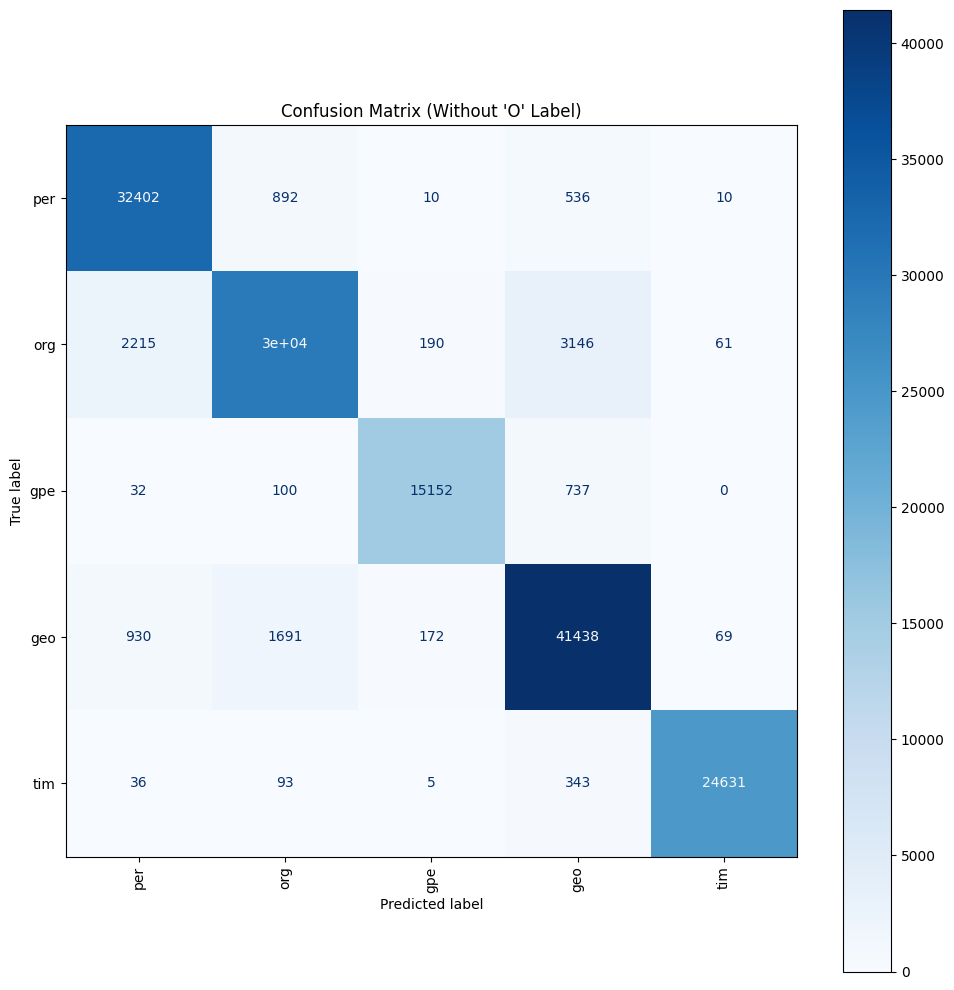

<Figure size 640x480 with 0 Axes>

In [45]:
filtered_labels = [label for label in label_list if label != 'O']

# Filter predictions and labels
filtered_preds_flat = []
filtered_labels_flat = []
for pred, label in zip(all_preds_flat, all_labels_flat):
    if label != 'O':
        filtered_preds_flat.append(pred)
        filtered_labels_flat.append(label)

filtered_labels = list(set(map(lambda x: x[2:], filtered_labels)))
filtered_labels_flat = list(map(lambda x: x[2:], filtered_labels_flat))
filtered_preds_flat = list(map(lambda x: x[2:], filtered_preds_flat))

# Generate Confusion Matrix
cm = confusion_matrix(filtered_labels_flat, filtered_preds_flat, labels=filtered_labels)

# Display Confusion Matrix
fig, ax = plt.subplots(figsize=(10, 10)) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=filtered_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)
plt.title("Confusion Matrix (Without 'O' Label)")
plt.tight_layout()
plt.show()
plt.savefig("cm.png")


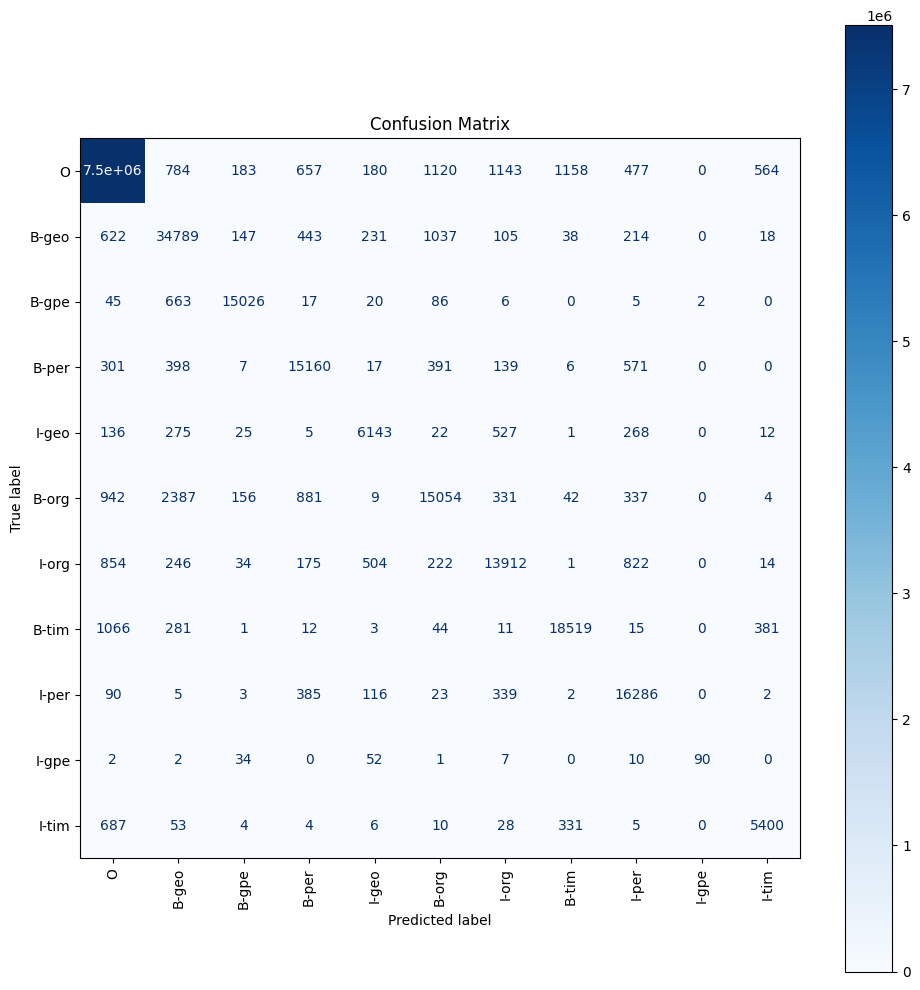

<Figure size 640x480 with 0 Axes>

In [46]:
# Generate Confusion Matrix
cm = confusion_matrix(all_labels_flat, all_preds_flat, labels=label_list)

# Display Confusion Matrix
fig, ax = plt.subplots(figsize=(10, 10)) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_list)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
plt.savefig("cmo.png")
